# Blender Scripting ...

When modeling a CG virtual scene, we may have to think three atributes of the scene.

SCENE STATE MODELING PHASE:

(a) Scene Geometry : Object placements, shapes, orientations in the world coordinate system

(b) Scene Photometry: Light source's intensity, color spectrum, weather effects, camera effects etc.

(c) Scene Dynamics: Animating the objects and photometric parameters of the scene. 


In [1]:
from IPython.display import Image
Image(filename='graphical_model.PNG')


The above image shows the high level overview of generative process of an image. To design a 3D scene state, we may have to consider setting all these parameters. We use Blender to do the same.

In this tutorial, I will try to give an overview of blender scipting interface.

This is needed to automate scene generation using other python packages. 

to install Blender..

sudo add-apt-repository ppa:thomas-schiex/blender

sudo apt-get update

sudo apt-get install blender


# Hello Blender

In [ ]:
%%bash
blender --python-console --engine CYCLES

In [ ]:
# bpy is high level api for blender python interace
import bpy 

'''
it provides several important apis for parametric scene modeling..

bpy ## Top level Blender Python API module
--->bpy.data
--->--->bpy.data.objects
--->--->bpy.data.materials
--->--->bpy.data.images
--->--->bpy.data.cameras
--->--->bpy.data.meshes
--->bpy.ops
--->--->bpy.ops.object
--->--->bpy.ops.camera
--->--->bpy.ops.import_scene
--->--->bpy.ops.render
--->bpy.context
--->bpy.props
--->Mathutils
--->Geometry
--->BGL

'''

In [ ]:
print(len(bpy.data.objects))  ## it should be print 3, as there are in 3 objects in the startup scene: Cude, Camera, Lamp

In [ ]:
# lets remove the cube and design our scene
for object in bpy.data.objects:
    if object.type == 'MESH':
        object.select = True
    else:
        object.select = False
bpy.ops.object.delete()

# now if you print the number of bpy.data.objects, it should be 2     

In [ ]:
## removing objects from the scene doesnot necessarily clear the cache
for mesh in bpy.data.meshes:
    bpy.data.meshes.remove(mesh)
for material in bpy.data.materials:
    bpy.data.materials.remove(material)

# Camera setting

In [ ]:
## one can add the cameras by using

# bpy.ops.object.camera_add()

## we already have camera in the scene.. 

## set extrinsic parameters of the camera
import math
PI = math.pi
bpy.data.objects['Camera'].location = (-8.0,0.0,0.5)
bpy.data.objects['Camera'].rotation_euler = (90*PI/180.0,0.0,-90.0*PI/180.)
## camera intrisic parameters 
bpy.data.cameras['Camera'].lens_unit = 'MILLIMETERS' # 'FOV'
bpy.data.cameras['Camera'].lens = 40.0 

## one can also code PSF, or camera trasfer function and set as follows
#bpy.ops.scripts.python_file_run(filepath='your script location')


# Light source

In [ ]:
# we have already a lamp in the scene
#change its type to SUN
bpy.data.lamps[0].type  = 'SUN'
bpy.data.lamps[0].name = 'Sun'
bpy.data.objects['Lamp'].name = 'Sun'
    
## light source extrinsic parameters
bpy.data.objects['Sun'].location = (0.0,0.0,5.0)
bpy.data.objects['Sun'].rotation_euler = (0.0,0.0,0.0)

## light source intrinsic paramters (color spectrum and intensity)
bpy.data.lamps['Sun'].use_nodes = True
bpy.data.lamps['Sun'].node_tree.nodes['Emission'].inputs['Color'].default_value = [1.0,1.0,1.0,1.0]
bpy.data.lamps['Sun'].node_tree.nodes['Emission'].inputs['Strength'].default_value = 4


# Ground plane

In [ ]:
##### GROUND

## lets add ground mesh
bpy.ops.mesh.primitive_plane_add(radius=10, location=(0,0,0))
bpy.data.objects['Plane'].name = 'Ground'

# add a diffuse BRDF
if len(bpy.data.materials)==0:
    bpy.ops.materials.new()

bpy.data.materials[0].name = 'Ground_material'

# link the material to mesh
bpy.data.objects['Ground'].active_material = bpy.data.materials['Ground_material']

bpy.data.materials['Ground_material'].use_nodes = True

# now you can play with BRDF 
albedo = (0.0,1.0,0.0,1.0)
roughness = 0.1

bpy.data.materials['Ground_material'].node_tree.nodes['Diffuse BSDF'].inputs['Color'].default_value = albedo
bpy.data.materials['Ground_material'].node_tree.nodes['Diffuse BSDF'].inputs['Roughness'].default_value = roughness


# render it once

In [ ]:
def render(filepath, frames=1, samples=10):
	bpy.data.scenes['Scene'].frame_end =frames
	bpy.data.scenes['Scene'].render.filepath = filepath
	bpy.data.scenes['Scene'].cycles.samples = samples
	bpy.ops.render.render(animation=True)

render(filepath='output/init', frames=1, samples=10) 

In [2]:
Image(filename='output/init0001.png')

# Adding Texturemaps

In [ ]:
## let us add texture to the ground plane

## load the texture map
bpy.ops.image.open(filepath='textures/texture_sand.jpg')
## add a image texture node
img_node = bpy.data.materials['Ground_material'].node_tree.nodes.new(type="ShaderNodeTexImage")
##link texture map to the node
img_node.image = bpy.data.images['texture_sand.jpg']
#bpy.data.materials['Ground_material'].node_tree.nodes['Image Texture'].image = bpy.data.images['ground_tex.jpg']
# now link albedo to texture map
bpy.data.materials['Ground_material'].node_tree.links.new(img_node.outputs['Color'], bpy.data.materials['Ground_material'].node_tree.nodes['Diffuse BSDF'].inputs['Color'])

## now we need to uv wrap it

bpy.ops.object.mode_set(mode = 'EDIT')
bpy.ops.mesh.select_all(action = 'SELECT')
bpy.ops.uv.unwrap()
bpy.ops.mesh.select_all(action = 'DESELECT')
bpy.ops.object.mode_set(mode = 'OBJECT')


# Sky

In [ ]:
#### SKY
world = bpy.data.worlds['World']
world.use_nodes = True
sky_tex = world.node_tree.nodes.new(type='ShaderNodeTexSky')
world.node_tree.links.new(sky_tex.outputs['Color'], world.node_tree.nodes['Background'].inputs['Color'])

render(filepath='output/gnd_sky', frames=1, samples=10) 

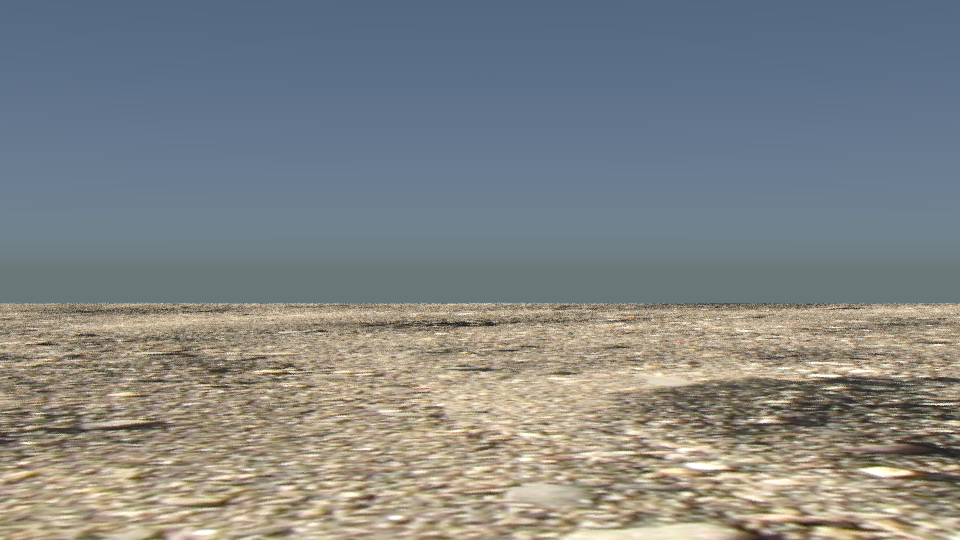

In [3]:
Image('output/gnd_sky0001.png')

# Random Clouds

In [ ]:
### RANDOM CLOUDS

noise = world.node_tree.nodes.new(type='ShaderNodeTexNoise')

ramp = world.node_tree.nodes.new(type='ShaderNodeValToRGB')

mix = world.node_tree.nodes.new(type='ShaderNodeMixRGB')

world.node_tree.links.new(sky_tex.outputs['Color'], world.node_tree.nodes['Mix'].inputs['Color1'])

world.node_tree.links.new(world.node_tree.nodes['Noise Texture'].outputs['Color'], ramp.inputs['Fac'])

world.node_tree.links.new(ramp.outputs['Color'], world.node_tree.nodes['Mix'].inputs['Color2'])

world.node_tree.links.new(world.node_tree.nodes['Mix'].outputs['Color'], world.node_tree.nodes['Background'].inputs['Color'])

bpy.data.worlds['World'].node_tree.nodes['ColorRamp'].color_ramp.elements[0].position = 0.3


render(filepath='output/clouds', frames=1, samples=10) 


In [4]:
Image('output/clouds0001.png')

You can play with the parameters of these node shaders to randomly change cloud's appearance 

# Road and It's texture

In [5]:
##### ROAD  

bpy.ops.mesh.primitive_plane_add(radius=1)
bpy.data.objects['Plane'].name = 'Road'
bpy.data.objects['Road'].location = [0.0,0.0,0.001]
bpy.data.objects['Road'].scale = [8.0,1.0,1.0]

### add a material BRDF
bpy.ops.material.new()
bpy.data.materials[-1].name = 'road_mat'
bpy.data.materials['road_mat'].use_nodes = True
bpy.data.objects['Road'].active_material = bpy.data.materials['road_mat']

## now add a texture map 

bpy.ops.image.open(filepath = 'textures/road.jpg')

# lets add an image texture node
img_node = bpy.data.materials['road_mat'].node_tree.nodes.new(type='ShaderNodeTexImage')
img_node.image = bpy.data.images['road.jpg']
bpy.data.materials['road_mat'].node_tree.links.new(img_node.outputs['Color'], bpy.data.materials['road_mat'].node_tree.nodes['Diffuse BSDF'].inputs['Color'])

### select road as active object
bpy.context.scene.objects.active = bpy.data.objects['Road']
bpy.ops.object.mode_set(mode = 'EDIT')
bpy.ops.mesh.select_all(action = 'SELECT')
bpy.ops.uv.smart_project() # automatically unwrap object
bpy.ops.mesh.select_all(action = 'DESELECT')
bpy.ops.object.mode_set(mode = 'OBJECT')

render(filepath='output/road', frames=1, samples=10) 

NameError: name 'bpy' is not defined

In [6]:
Image('output/road0001.png')

# Importing CAD (Buildings, Trees, Persons, Vehicles etc)

3D Designing every thing from scratch is difficult and time taking process. Lets import some existing CAD models. 

In [ ]:
# let me have some filenames to point my objects to be imported

### CADs folder

folder = '/home/subbu/tutorial_blender/cads/'
building = 'building_17'
tree = 'tree_1'
car = 'car_2'
person = 'person_3'
ext = '.blend'
for item in [building, tree, car, person]:
	section = '\\Object\\'
	directory = folder+item+ext+section
	filename = item
	bpy.ops.wm.append(filename=filename, directory=directory)

## arrange the objects in scene layout
bpy.data.objects[building].location = [-2.33, -2.27,0.0]
bpy.data.objects[building].scale = [0.26,0.26,0.26]
bpy.data.objects[person].location = [-5.0, -0.78, 0.0]
bpy.data.objects[person].scale = [.165, 0.165, 0.165]
bpy.data.objects[person].rotation_euler = [90*PI/180, 0, -90*PI/180]
bpy.data.objects[tree].location = [-2.0, 1.3, 0.0]
bpy.data.objects[tree].scale = [.007, 0.007, 0.007]
bpy.data.objects[car].location = [-5.5, 0.4, 0.0]
bpy.data.objects[car].scale = [.006, 0.006, 0.006]
bpy.data.objects[car].rotation_euler = [90*PI/180, 0, 180*PI/180]


##let us see the result
render(filepath='output/scene', frames=1, samples=10)

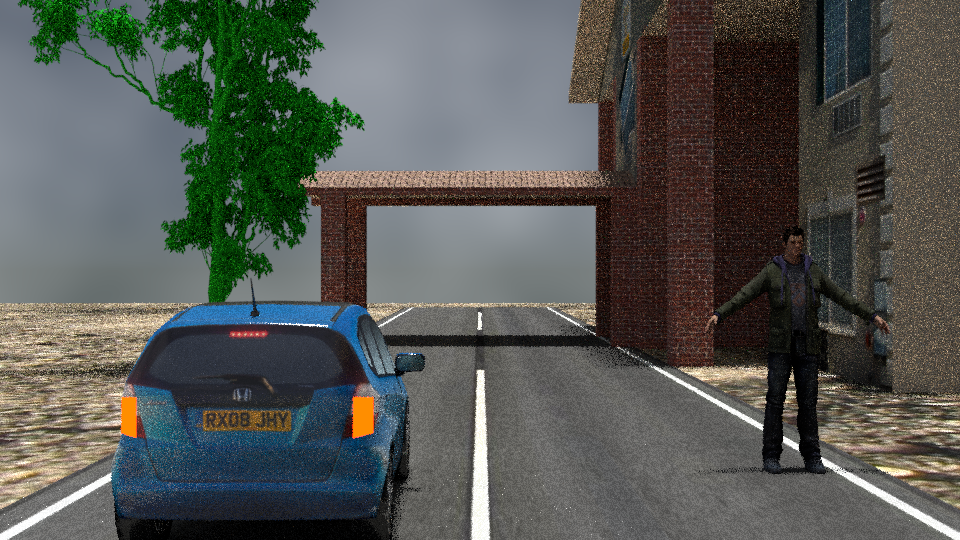

In [8]:
Image('output/scene0001.png')

In [ ]:
### let us add a little more objects into the scene, duplicating the existing objects
import numpy as np
bpy.ops.object.select_all(action='DESELECT') 
bpy.data.objects[tree].select = True
for i in np.arange(9):
	x1 = np.random.uniform(low=-4, high=10)
	y1 = np.random.uniform(low=1, high=4)
	bpy.ops.object.duplicate(linked=True)
	ex = '.00'+str(i+1) if i+1<10 else '.0'+str(i+1)
	bpy.data.objects[tree+ex].location = (x1,y1,0)



bpy.ops.object.select_all(action='DESELECT') 
bpy.data.objects[car].select = True
for i in np.arange(4):
	x1 = np.random.uniform(low=0, high=6)
	y1 = np.random.uniform(low=-1, high=1)
	bpy.ops.object.duplicate(linked=True)
	ex = '.00'+str(i+1) if i+1<10 else '.0'+str(i+1)
	bpy.data.objects[car+ex].location = (x1,y1,0)

# Weather 

In [ ]:
##### Lets play with the weather 
# there are lot of simulate weather effects, for example, if you consider video games, they go for for simple 
# postprocessing techniques for the sake of real time rendering
# but here lets do it in physically realsitic way

bpy.ops.mesh.primitive_cube_add(radius=10)
bpy.data.objects['Cube'].location = (0,0,0)
bpy.ops.material.new()
bpy.data.materials['Material'].name = "Media"
media = bpy.data.materials['Media']
vol_node = media.node_tree.nodes.new(type='ShaderNodeVolumeScatter')
media.node_tree.links.new(vol_node.outputs['Volume'], media.node_tree.nodes['Material Output'].inputs['Volume'])
media.node_tree.links.remove(media.node_tree.nodes['Material Output'].inputs['Surface'].links[0])
vol_node.inputs['Density'].default_value = 0.1
vol_node.inputs['Anisotropy'].default_value = 0.5

bpy.data.objects['Cube'].active_material = media

render(filepath='output/weather', frames=1, samples=10) 

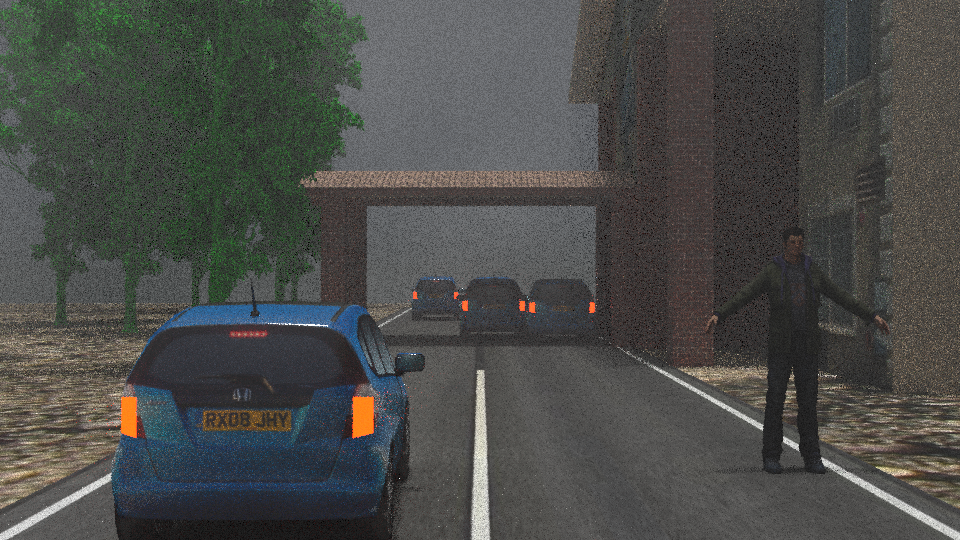

In [10]:
Image('output/weather0001.png')

# Annotations

In [ ]:

def SemanticAnnotations():
	## color coding of annotations.. 
	OBJECTS = {  
	'ROAD' : (128/255.0, 64/255.0, 128/255.0, 1.0),
	'GROUND' : (244/255.0, 35/255.0, 232/255.0, 1.0),
	'CAR' : (0/255.0, 0/255.0, 142/255.0, 1.0),
	'BUILDING' : (70/255.0, 70/255.0, 70/255.0, 1.0),
	'TREE' :  (107/255.0, 142/255.0, 35/255.0, 1.0),
	'SKY' : (70/255.0, 130/255.0, 180/255.0, 1.0),
	'PERSON' : (220/255.0, 20/255.0, 60/255.0, 1.0),
	}

	## use passindex as object identifiers
	bpy.data.objects['Road'].pass_index = 1
	bpy.data.objects['Ground'].pass_index = 2
	bpy.data.objects[building].pass_index = 3
	bpy.data.objects[person].pass_index = 4
	for obj in bpy.data.objects:
		if obj.name[0] == 't':
			obj.pass_index = 5
		if obj.name[0] == 'c':
			obj.pass_index = 6




	scene = bpy.data.scenes['Scene']
	scene.use_nodes = True
	scene.render.layers['RenderLayer'].use_pass_object_index = True

	node_tree = scene.node_tree

	

	### a mask node for car objects
	idmask_car = node_tree.nodes.new(type='CompositorNodeIDMask')
	idmask_car.name = 'idmask'+'_car'
	idmask_car.index = 6
	node_tree.links.new(scene.node_tree.nodes['Render Layers'].outputs['IndexOB'], 
			idmask_car.inputs['ID value'])
	## multiply node for color code
	multiply_node_car = node_tree.nodes.new(type='CompositorNodeMixRGB')
	multiply_node_car.blend_type = 'MULTIPLY'
	multiply_node_car.inputs[1].default_value = OBJECTS['CAR']
	node_tree.links.new(idmask_car.outputs['Alpha'], multiply_node_car.inputs[2])

	### a mask node for person objects
	idmask_person = node_tree.nodes.new(type='CompositorNodeIDMask')
	idmask_person.name = 'idmask'+'_person'
	idmask_person.index = 4
	node_tree.links.new(scene.node_tree.nodes['Render Layers'].outputs['IndexOB'], 
			idmask_person.inputs['ID value'])
	## multiply node for color code
	multiply_node_person = node_tree.nodes.new(type='CompositorNodeMixRGB')
	multiply_node_person.blend_type = 'MULTIPLY'
	multiply_node_person.inputs[1].default_value = OBJECTS['PERSON']
	node_tree.links.new(idmask_person.outputs['Alpha'], multiply_node_person.inputs[2])

	add_node = node_tree.nodes.new(type='CompositorNodeMixRGB')
	add_node.blend_type = 'ADD'
	node_tree.links.new(multiply_node_car.outputs['Image'], add_node.inputs[1])
	node_tree.links.new(multiply_node_person.outputs['Image'], add_node.inputs[2])
	

	## add a file output node
	GT_node = node_tree.nodes.new(type='CompositorNodeOutputFile')
	GT_node.base_path = 'output/'
	node_tree.links.new(add_node.outputs['Image'], GT_node.inputs['Image'])

	render(filepath='output/annotate', frames=1, samples=10)
	
	
SemanticAnnotations()

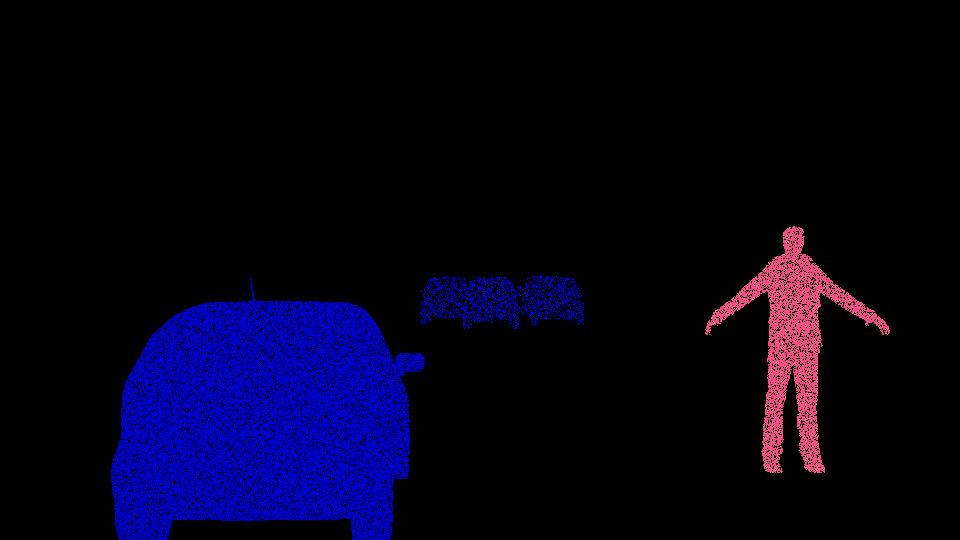

In [12]:
Image('output/Image0001.png')

# Scripting Custom Nodes

In [ ]:
### library of invariants
### date: 01-10-2015
### author: subbu veeravasarapu

import bpy
from bpy.types import NodeTree, Node, NodeSocket

### (1) define QuasiInvariantsTree
class QuasiInvariantTree(NodeTree):
	''' library of invariants '''
	bl_idname = 'QuasiInvariantTreeType'
	bl_label = 'Quasi Invariant Tree'
	
class QuasiInvariantTreeNode:
	@classmethod
	def poll(cls, ntree):
		b=False
		if ntree.bl_idname == 'QuasiInvariantTreeType': b=True
		#if ntree.bl_idname == 'ShaderNodeTree': b=True
		if ntree.bl_idname == 'CompositorNodeTree': b=True
		return b
		
class QuasiInvariantNode(Node, QuasiInvariantTreeNode):
	''' An quasi-invariant node '''
	bl_idname = 'QuasiInvariantNodeType'
	bl_label = 'QuasiInvariant Node'
	bl_icon = 'SOUND'
	
	def update_values(self, context):
		self.outputs["TransformedImage"].default_value = self.block_size
		self.update()
		print(self.outputs["TransformedImage"].default_value)
	
	### outputs 
	#transformed_image = bpy.props.IntProperty(default=12)
	
	my_items = [
        ("RO", "RankOrder", "Rank order transform only"),
        ("DCTROa", "DCT-RankOrder-all", "Rank order on all DCT coefficients in a block "),
        ("DCTROr", "DCT-RankOrder-radial", "Rank order on radial DCT coefficients in a block "),
        ("DCTROe", "DCT-RankOrder-extreme", "Rank order on extremal DCT coefficients in a block ")		
    ]
	qiEnumProperty = bpy.props.EnumProperty(name="Quasi-invariant", description="A quasi-invariant transformation", items=my_items, default='RO')
	block_size = bpy.props.IntProperty(name="Block-Size", default=12, update=update_values)
	
	def init(self, context):
		self.inputs.new('NodeSocketColor', "InputImage")
		self.outputs.new('NodeSocketInt', "TransformedImage")
		self.outputs["TransformedImage"].default_value = self.block_size
		#self.outputs.new('NodeSocketFloat', "Float")
	
	def update(self):
		try:
			out = self.outputs["TransformedImage"]
			can_continue = True
		except:
			can_continue = False
		
		if can_continue:
			if out.is_linked:
				for o in out.links:
					if o.is_valid:
						o.to_socket.node.inputs[o.to_socket.name].default_value = self.outputs["TransformedImage"].default_value
		
	
	def draw_buttons(self, context, layout):
		#layout.prop(self, "transformed_image", text='')
		layout.prop(self, "qiEnumProperty", text='Algo')
		layout.prop(self, "block_size", text='Block Size')
	def draw_label(self):
		return "custom quasi-invariant node"

		
### distnace nodes
class DistanceNode(Node, QuasiInvariantTreeNode):
	''' An quasi-invariant node '''
	bl_idname = 'DistanceNodeType'
	bl_label = 'Distance Node'
	bl_icon = 'SOUND'
	
	dist_items = [
        ("L2Norm", "Euclidean", "Rank order transform only"),
        ("qPAV", "q-PAV", "Rank order on all DCT coefficients in a block "),
        ("NCC", "NCC", "Rank order on radial DCT coefficients in a block "),
        ("Hamming", "Hamming-Distance", "Rank order on extremal DCT coefficients in a block ")		
    ]
	distEnumProperty = bpy.props.EnumProperty(name="Distance", description="A distance transformation", items=dist_items, default='L2Norm')
	#def init(self, context):
		#self.inputs.new('NodeSocketColor', "InputImage")
		#self.outputs.new('NodeSocketInt', "TransformedImage")
	
	# def draw_buttons(self, context, layout):
		#layout.prop(self, "transformed_image", text='')
		# layout.prop(self, "distEnumProperty", text='Distance Algo')
		#layout.prop(self, "block_size", text='Block Size')
	# def draw_label(self):
		# return "custom distance node"
	

### (2) node categories
import nodeitems_utils
from nodeitems_utils import NodeCategory, NodeItem

class QuasiInvariantNodeCategory(NodeCategory):
	@classmethod
	def poll(cls, context):
		b = False
		#if context.space_data.tree_type == 'ShaderNodeTree': b=True
		if context.space_data.tree_type == 'CompositorNodeTree': b=True
		return b

node_categories = [
	# identifier, label, itemslist
	QuasiInvariantNodeCategory("SOMENODES", "Invariant Node", items=[
		NodeItem("QuasiInvariantNodeType"),
		]
	),
	QuasiInvariantNodeCategory("CUSTOMNODES", "Distance Node", items=[
		NodeItem("DistanceNodeType"),
		]
	),
]


### (3) take care of animations
def pre_frame_change(scene):
	if scene.render.engine == 'CYCLES':
		for m in bpy.data.materials:
			if m.node_tree != None:
				for n in m.node_tree.nodes:
					if n.bl_idname == 'QuasiInvariantNodeType':
						print(n.bl_idname)
						## lets update custom nodes
						v = n.block_size
						n.block_size = v


### (4) define register and unregister functions
def register():
	bpy.utils.register_class(QuasiInvariantNode)
	nodeitems_utils.register_node_categories("QUASIINVARIANT_NODES", node_categories)
	
def unregister():
	bpy.utils.unregister_class(QuasiInvariantNode)
	nodeitems_utils.unregister_node_categories("QUASIINVARIANT_NODES")
	

if __name__ == "__main__":
	register()	
	bpy.app.handlers.frame_change_pre.append(pre_frame_change)